In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install pydicom -q
!pip install nilearn -q
!pip install nibabel -q
!pip install -q plotly 
!pip install -q scikit-image

In [2]:
# Import general packages
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [3]:
data_path = "/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15"
output_path = working_path = "/content/output/"
g = glob(data_path + '/*')

# Print out the first 5 file names to verify we're in the right folder.
print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))

first5img = '\n'.join(g[:5])
print(first5img)

Total of 508 DICOM images.
First 5 filenames:
/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15/000020.dcm
/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15/000018.dcm
/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15/000016.dcm
/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15/000001.dcm
/content/drive/MyDrive/CSE BIOE-320 420-SP23/hw_project/Assig2/CT-CASE15/000022.dcm


In [4]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
  
patient = load_scan(data_path)

## Processing Images

In [5]:
# Loop over the image files and store everything into a list.

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans], axis=-1)
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -3000] = 0
    
    # Convert to Hounsfield units (HU)
    # The rescale slope and rescale intercept allow to transform the pixel values to HU or other units
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    # Pixel -> HU: slope * x + intercept
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

img = get_pixels_hu(patient)

In [6]:
# Check data shape
from scipy import ndimage

# img_new = img.transpose(2, 0, 1).  # transform data dimensions from xyz to zxy

img_new = ndimage.rotate(img, -90, reshape=False)

img_new.shape

(512, 512, 508)

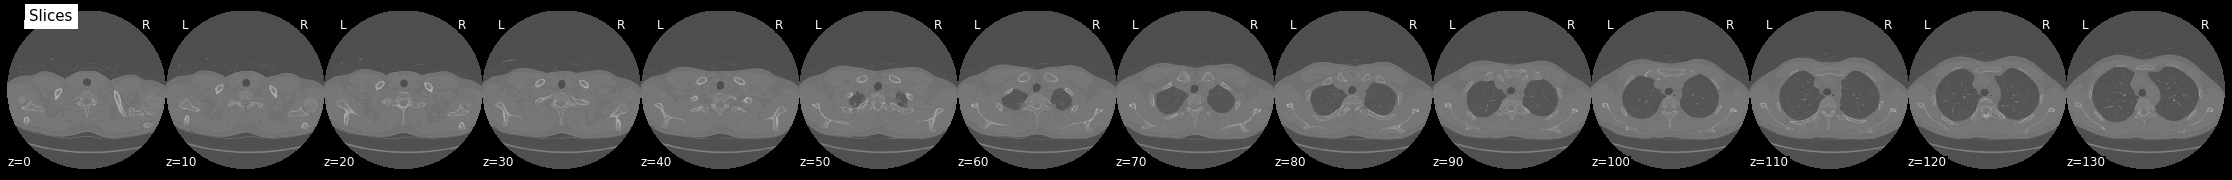

In [7]:
# Displaying an Image Stack

from nilearn import plotting
import nibabel as nib

# transform data into nii format
img_nii = nib.Nifti1Image(img_new, affine=np.eye(4))

# Visualize slices
plotting.plot_anat(img_nii, display_mode= 'z', cut_coords=range(0, 139, 10), title='Slices')

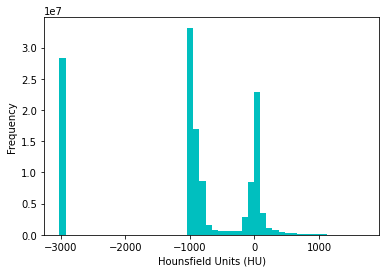

In [8]:
# Create a histogram of all the voxel data.

img_to_process = img_new.astype(np.float64)

plt.hist(img_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Display Voxel Size

In [9]:
# This is in the DICOM header.

print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 0.625000
Pixel Spacing (row, col): (0.683594, 0.683594) 


### Resampling

In [10]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, (list(scan[0].PixelSpacing)) + [scan[0].SliceThickness])
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", img_to_process.shape)
img_after_resamp, spacing = resample(img_to_process, patient, [1,1,1])
print("Shape after resampling\t", img_after_resamp.shape)

Shape before resampling	 (512, 512, 508)


<ipython-input-10-f66707e9c4ed>:12: DeprecationWarning:

Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.



Shape after resampling	 (350, 350, 318)


In [11]:
# Save the new image to file

affine = np.eye(4)
array_img = nib.Nifti1Image(img_after_resamp, affine)
nib.save(array_img, os.path.join(output_path,'raw_new.nii'))

## 3D Plot

In [33]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    # p = image.transpose(2,1,0)
    p = image
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)   # default spacing=(1.0, 1.0, 1.0)

    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    # colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    # ax.set_facecolor((0.7, 0.7, 0.7))
    ax.set_facecolor((1, 1, 1))
    plt.show()

Transposing surface
Calculating surface
Drawing


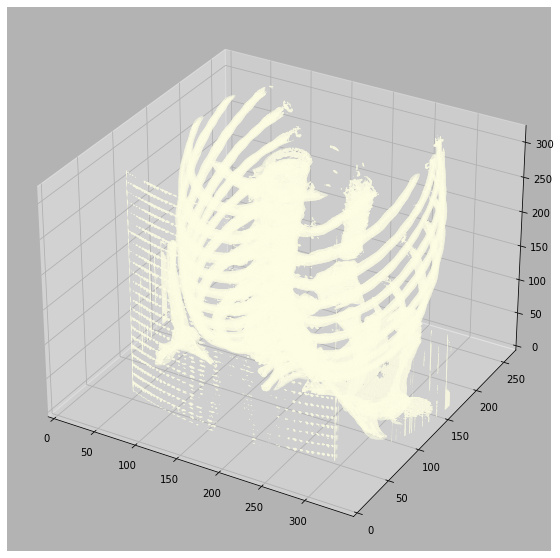

In [15]:
v, f = make_mesh(img_after_resamp, 350)
plt_3d(v, f)

## Segmentation

In [13]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std

    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]   # Lung image
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, we can move the underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate background (soft tissue/bone) and foreground (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)  # Measure properties of labeled image regions - each item describes one labeled region
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)    # only lung/airway mask
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')            # Show original image
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")              
        ax[0, 1].imshow(thresh_img, cmap='gray')     # Show thresholded image 
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')       # Show dilation image
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')           # Show mask image for lung/airway
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')       # Map mask to image
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

## Simple Example At Each Step

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



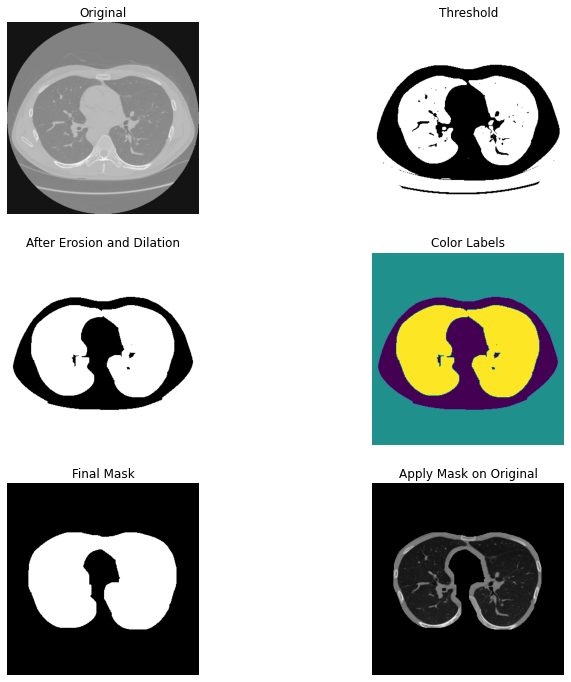

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [14]:
img_target = ndimage.rotate(img_after_resamp, 180, reshape=False)

img_target = img_target.transpose(2,1,0)

fiber = img_target[150]
make_lungmask(fiber, display=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

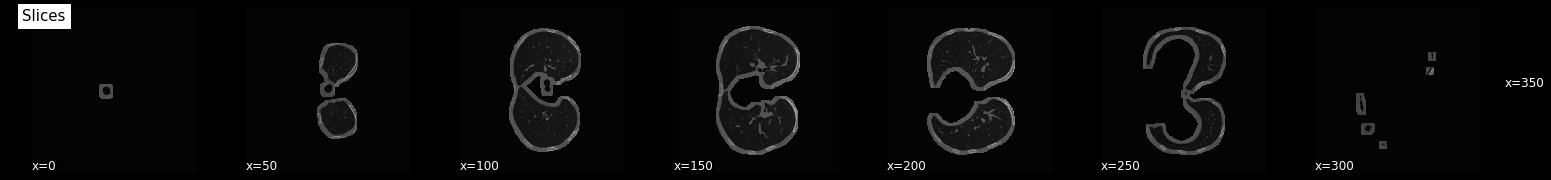

In [15]:
masked_lung = []

# Repeat to process image slice by slice
for i in img_target:
    masked_lung.append(make_lungmask(i))

masked_lung = np.array(masked_lung)

# transform data into nii format
masked_lung_img_nii = nib.Nifti1Image(masked_lung, affine=np.eye(4))

# Visualize slices
plotting.plot_anat(masked_lung_img_nii, display_mode= 'x', cut_coords=range(0, 358, 50), title='Slices')

In [16]:
# save segmentation result to file
nib.save(masked_lung_img_nii, os.path.join(output_path, 'masked_lung_img.nii'))

Transposing surface
Calculating surface
Drawing


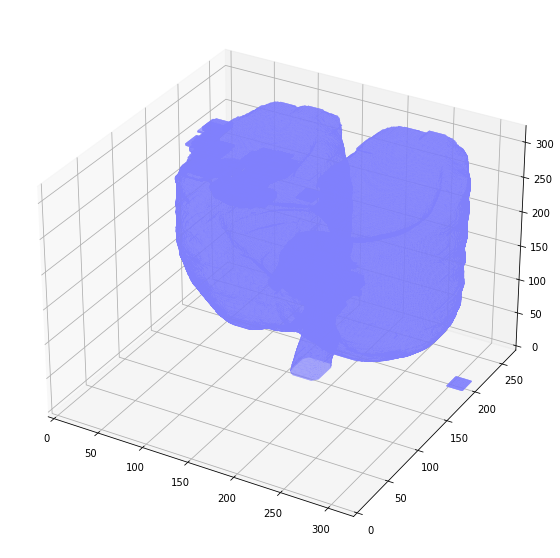

In [34]:
from skimage import io
masked_img_arrary = io.imread('/content/output/masked_lung_img.nii')
verts, faces = make_mesh(masked_img_arrary, 0)
plt_3d(verts, faces)

In [19]:
!pip install itk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 28.8 MB/s eta 0:00:00
